In [1]:
import os

In [2]:
from langgraph.graph import MessagesState,StateGraph, END, START
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.prebuilt import tools_condition # this is the checker for the if you got a tool back
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from typing import Annotated, TypedDict
import operator
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition # this is the checker for the
from langgraph.prebuilt import ToolNode

In [3]:
from langchain_openai import ChatOpenAI
#Initializing the language model
llm = ChatOpenAI(model="gpt-4o")

In [4]:
def multiply(a: int, b: int) -> int:
    """
    Multiply a and b.
    Args:
        a: first int
        b: second int
    """
    return a * b

In [5]:
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

In [6]:
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

In [7]:
from langchain_community.tools import TavilySearchResults

search = TavilySearchResults(
    max_results=5,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True
)

In [8]:
search.invoke("who is a current president of USA?")

[{'url': 'https://simple.wikipedia.org/wiki/President_of_the_United_States',
  'content': 'The president is also the head of the executive branch of the federal government of the United States and is the chairman of the presidential cabinet.[10]\nJoe Biden is the 46th and current president of the United States, in office since January 2021.[11]\nEligibility and requirements[change | change source]\nArticle II, Section 1, Clause 5 of the constitution states for a person to serve as president must:\nElection process and presidential terms[change | change source]\nThe president is elected by the people through the Electoral College to a four-year term, along with the vice presidential candidate or the incumbent vice president of the United States as their running mate.[12] Contents\nPresident of the United States\nThe president of the United States (POTUS)[9] is the head of state and head of government of the United States of America and the commander-in-chief of the United States Armed F

In [9]:
tools = [add, multiply, divide, search]

In [10]:
llm_with_tools=llm.bind_tools(tools)

In [11]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs.")

In [12]:
def reasoner(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

In [13]:
# Graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("reasoner", reasoner)

builder.add_node("tools", ToolNode(tools)) # for the tools

# Add edges
builder.add_edge(START, "reasoner")

builder.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)

builder.add_edge("tools", "reasoner")
react_graph = builder.compile()

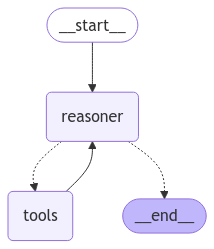

In [14]:
# Display the graph
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [15]:
messages = [HumanMessage(content="What is 2 times of Dhoni's age?")]

In [16]:
messages = react_graph.invoke({"messages": messages})

In [17]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 times of Dhoni's age?
================================== Ai Message ==================================

In order to calculate "2 times of Dhoni's age," I need to know the current age of Mahendra Singh Dhoni. Let me look up his current age.
Tool Calls:
  tavily_search_results_json (call_3FSmvkabM1UDwbLTZ0YA0CQV)
 Call ID: call_3FSmvkabM1UDwbLTZ0YA0CQV
  Args:
    query: MS Dhoni current age 2023
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://cricketbioguru.com/ms-dhoni-age-height-biography-and-his-journey/", "content": "MS Dhoni Age and Height. The well-known Indian cricket player MS Dhoni is roughly 5 feet 9 inches (175 cm) tall. He was born on July 7, 1981. MS Dhoni age is 42 years old in 2023. MS Dhoni Wife & Personal life. MS Dhoni wife is Sakshi Singh Rawat, married on 4 July 2010 in Dehradun. In his person

In [18]:
import yfinance as yf

def get_stock_price(ticker: str) -> float:
    """Gets a stock price from Yahoo Finance.

    Args:
        ticker: ticker str
    """
    # """This is a tool for getting the price of a stock when passed a ticker symbol"""
    stock = yf.Ticker(ticker)
    return stock.info['previousClose']

In [19]:
get_stock_price("AAPL")

259.02

In [20]:
# Node
def reasoner(state):
    query = state["query"]
    messages = state["messages"]
    # System message
    sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs.")
    message = HumanMessage(content=query)
    messages.append(message)
    result = [llm_with_tools.invoke([sys_msg] + messages)]
    return {"messages":result}

In [21]:
tools = [add, multiply, divide, search, get_stock_price]

In [22]:

llm_with_tools = llm.bind_tools(tools)

In [23]:
class GraphState(TypedDict):
    """State of the graph."""
    query: str
    finance: str
    final_answer: str
    # intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]
    messages: Annotated[list[AnyMessage], operator.add]

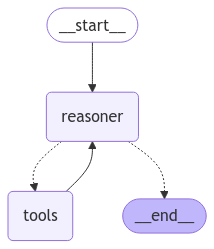

In [24]:
# Graph
workflow = StateGraph(GraphState)

# Add Nodes
workflow.add_node("reasoner", reasoner)
workflow.add_node("tools", ToolNode(tools)) # for the tools

# Add Edges
workflow.add_edge(START, "reasoner")

workflow.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)
workflow.add_edge("tools", "reasoner")
react_graph = workflow.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [25]:
response = react_graph.invoke({"query": "What is the stock price of Apple add 1000?", "messages": []})

In [26]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the stock price of Apple add 1000?
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (call_Q8n4XN9DCRRL6MF16FJURoBd)
 Call ID: call_Q8n4XN9DCRRL6MF16FJURoBd
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

259.02
================================ Human Message =================================

What is the stock price of Apple add 1000?
================================== Ai Message ==================================
Tool Calls:
  add (call_hXe5WI9cdrl1Ah39B9ZDu19O)
 Call ID: call_hXe5WI9cdrl1Ah39B9ZDu19O
  Args:
    a: 259
    b: 1000
================================= Tool Message =================================
Name: add

1259
================================ Human Message =================================

What is the stock price of Apple add 1000?
=======